<a href="https://colab.research.google.com/github/mirianfsilva/machine-learning/blob/master/deep-learning/transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
### Practical II - Machine Learning
#### Mírian Francielle 

- Objectives: 
The goal of this practical is to practice the use of Convolutional Neural Networks (CNNs) and Transfer Learning. In this practical you will compare three strategies for training CNNs, two of which use Transfer Learning, in an image classification problem. 

- Task:
Train a CNN to classify the images from part A using the Keras API for TensorFlow. 

- Dataset:  CIFAR-101 . This dataset has 60000 images of 32x32 pixels, of which 50000 are for training and 10000 for test. Each image belongs to one of 10 classes, numbered from 0 to 9. The classes are: airplane, automobile, bird, cat, deer, dog, frog,
horse, ship and truck. 

- References: [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)


In [0]:
import matplotlib
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import keras

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

In [21]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


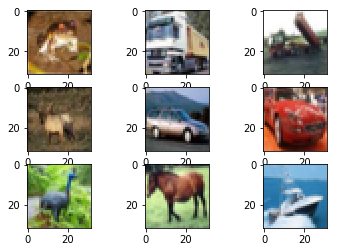

In [22]:
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i])
plt.show()


#### Dataset B: Classes 0 e 5  | Dataset A: Restante das Classes
Separação de dados de A e B, em treino e teste. 


In [0]:
#my_list = [x for x in my_list if x.attribute == value]
#my_list = filter(lambda x: x.attribute == value, my_list)
A, B = [], []

#Separando os dados de A e B de treino
B0 = list(filter(lambda x:x[1] in (0,5), enumerate(y_train)))
B0 = [idx[0] for idx in B0]
B0 = np.array(B0)

A0 = list(filter(lambda x:x[1] not in (0,5), enumerate(y_train)))
A0 = [idx[0] for idx in A0]
A0 = np.array(A0)

#Separando os dados de A e B de teste
B1 = list(filter(lambda x:x[1] in (0,5), enumerate(y_test)))
B1 = [idx[0] for idx in B1]
B1 = np.array(B1)

A1 = list(filter(lambda x:x[1] not in (0,5), enumerate(y_test)))
A1 = [idx[0] for idx in A1]
A1 = np.array(A1)

#===============================================

train_b0 = x_train[B0]
train_b1 = x_test[B1]
train_a0 = x_train[A0]
train_a1 = x_test[A1]

x_train_b = np.concatenate((train_b0, train_b1))
x_train_a = np.concatenate((train_a0, train_a1))


y_train_b0 = np.array(list(filter(lambda x:x in (0,5), y_train)))
y_train_b1 = np.array(list(filter(lambda x:x in (0,5), y_test)))

y_train_a0 = np.array(list(filter(lambda x:x not in (0,5), y_train)))
y_train_a1 = np.array(list(filter(lambda x:x not in (0,5), y_test)))

In [0]:
#Após transformação das listas em arrays, concatenar os dois arrays
y_train_a = np.concatenate((y_train_b0, y_train_b1), axis=0)
y_train_b = np.concatenate((y_train_b0, y_train_b1), axis=0)

### Tratamento dos dados

In [0]:
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

# Novo target
y_train_a = np.reshape(y_train_a, len(y_train_a))
y_train_b = np.reshape(y_train_b, len(y_train_b))


# Normalização
x_train_a = x_train_a/255
x_train_b = x_train_b/255

#One-hot encoding dos targets
y_train_a = pd.get_dummies(y_train_a).values
y_train_b = pd.get_dummies(y_train_b).values


# Pega o número de classes
n_classesA = y_train_a.shape[1]
n_classesB = y_train_b.shape[1]

In [0]:
x_train_A  = x_train_a[:int(len (x_train_a)* 0.8)]
y_train_A  = y_train_a[:int(len (y_train_a)* 0.8)]

x_test_A  = x_train_a[ int(len (x_train_a)* 0.8):]
y_test_A  = y_train_a[ int(len (y_train_a)* 0.8):]

In [0]:
x_train_B  = x_train_b[:int(len(x_train_b)* 0.8)]
y_train_B  = y_train_b[:int(len(y_train_b)* 0.8)]

x_test_B  = x_train_b[int(len(x_train_b)* 0.8):]
y_test_B  = y_train_b[int(len(y_train_b)* 0.8):]

### CNNs e modelos por época


In [0]:
#Variáveis padrão:
decay = 1e-6
weight_decay = 1e-6
strides = 1

In [51]:
model = Sequential()
layer = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_A.shape[1:], strides=strides, kernel_initializer='he_normal')
model.add(layer)

model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classesA, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [52]:
# Inicializa o otimizados.
optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
model.compile(optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

# Treina por 20 epocas com mini-batches
history = model.fit(x_train_A, y_train_A, batch_size=128, epochs=20, verbose=1, validation_data=(x_test_A, y_test_A))


scores = model.evaluate(x_test_A, y_test_A, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

ValueError: ignored

NameError: ignored

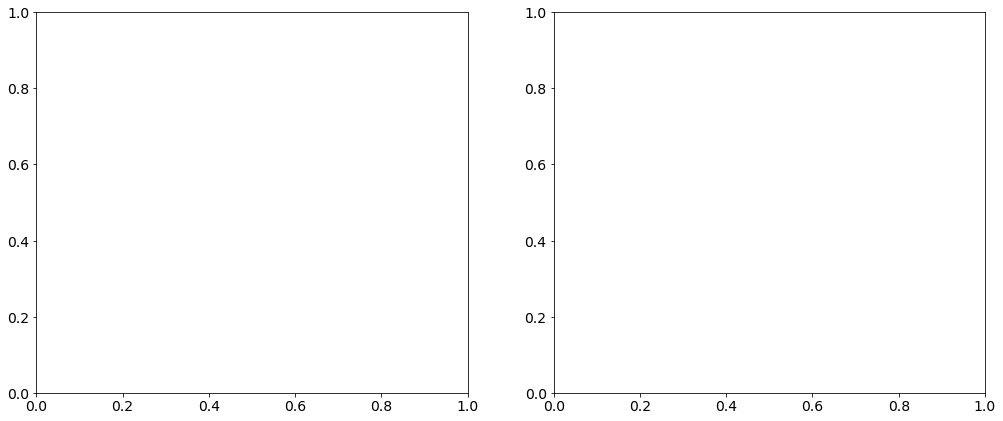

In [34]:
# Gera graficos do resultado do treino
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Loss
axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
        label="Train Loss", color="royalblue", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history.history["acc"])+1))
axes[0].legend()

# Accuracy
axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
        label="Train ACC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
        label="Teste ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history.history["acc"])+1))
axes[1].legend()
plt.show()

### Treino B - sem transfer learning

In [53]:
model = Sequential()
layer = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_B.shape[1:], strides=strides, kernel_initializer='he_normal')
model.add(layer)

model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classesB, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [54]:
# Inicializa o otimizador.
optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
model.compile(optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 200
# Treina por 20 epocas com mini-batches
history = model.fit(x_train_B, y_train_B, batch_size=128, epochs=20, verbose=1, validation_data=(x_test_B, y_test_B))

#testing
scores = model.evaluate(x_test_B, y_test_B, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Train on 9600 samples, validate on 2400 samples
Epoch 1/20
9600/9600 [==============================] - 3s 346us/step - loss: 0.9154 - acc: 0.8584 - val_loss: 0.2352 - val_acc: 0.9179
Epoch 2/20
9600/9600 [==============================] - 2s 225us/step - loss: 0.2100 - acc: 0.9249 - val_loss: 0.1492 - val_acc: 0.9437
Epoch 3/20
9600/9600 [==============================] - 2s 225us/step - loss: 0.1495 - acc: 0.9464 - val_loss: 0.2226 - val_acc: 0.9350
Epoch 4/20
9600/9600 [==============================] - 2s 225us/step - loss: 0.1186 - acc: 0.9567 - val_loss: 0.1355 - val_acc: 0.9571
Epoch 5/20
9600/9600 [==============================] - 2s 225us/step - loss: 0.0917 - acc: 0.9679 - val_loss: 0.1396 - val_acc: 0.9592
Epoch 6/20
9600/9600 [==============================] - 2s 226us/step - loss: 0.0669 - acc: 0.9790 - val_loss: 0.2184 - val_acc: 0.9342
Epoch 7/20
9600/9600 [==============================] - 2s 226us/step - loss: 0.0574 - acc: 0.9789 - val_loss: 0.1609 - val_acc: 0.9554


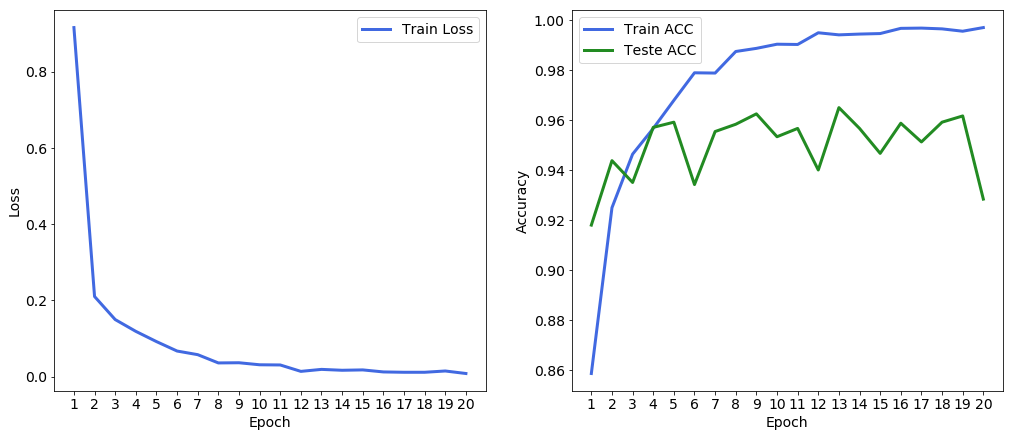

In [55]:
# Gera graficos do resultado do treino
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Loss
axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
        label="Train Loss", color="royalblue", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history.history["acc"])+1))
axes[0].legend()

# Accuracy
axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
        label="Train ACC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
        label="Teste ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history.history["acc"])+1))
axes[1].legend()
plt.show()

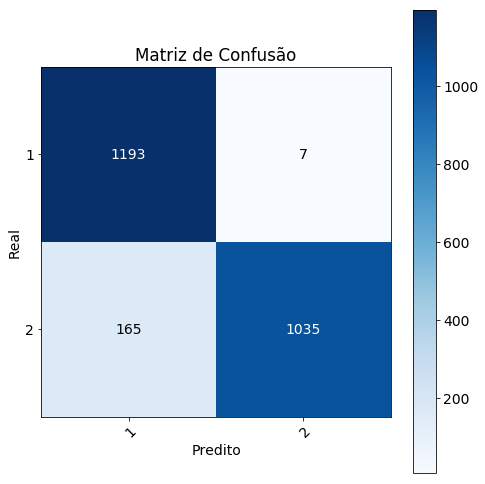

In [56]:
# Matriz de Confusao

# Predições
y_proba = model.predict(x_test_B)
y_pred = np.argmax(y_proba, axis=1)

y_true = np.argmax(y_test_B, axis=1)

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(1, 11))
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title="Matriz de Confusão",
       ylabel="Real",
       xlabel="Predito")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

In [57]:
# Matriz de Confusao

# Predições
y_proba = model.predict(x_test_A)
y_pred = np.argmax(y_proba, axis=1)

y_true = np.argmax(y_test_A, axis=1)

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(1, 11))
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title="Matriz de Confusão",
       ylabel="Real",
       xlabel="Predito")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

ValueError: ignored